<a href="https://colab.research.google.com/github/firas-bargui/corrosion-detection/blob/main/Rust_detection_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rust Detection using Mobile_Net

In [1]:
import keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.utils.vis_utils import plot_model

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

from keras.applications.mobilenet_v2 import MobileNetV2

import os, shutil
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import models
from keras.preprocessing import image
import numpy as np
import sklearn.metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import seaborn
print(keras.__version__)
print(tf.__version__)

2.8.0
2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
conv_base = MobileNetV2(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

9420800/9406464 [==============================] - 0s 0us/step


In [47]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                              

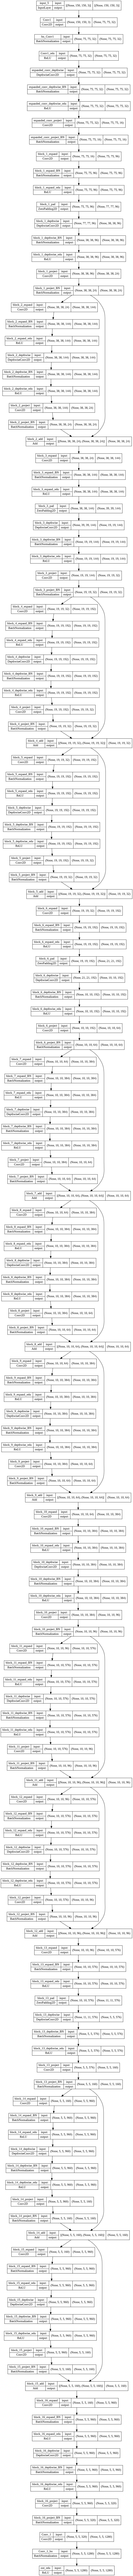

In [56]:
plot_model(conv_base, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [4]:
# The path to the directory where the training images are downloaded, change this as in your system
original_dataset_dir = '/content/drive/MyDrive/download'
original_dataset_dir_rust = '/content/drive/MyDrive/download/rust'
original_dataset_dir_norust = '/content/drive/MyDrive/download/norust'

# The directory where we will store our train, test and validation images
base_dir = '/content/model-MobileNet'


# Directories for our training,validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training rust pictures
train_rust_dir = os.path.join(train_dir, 'rust')

# Directory with our training norust pictures
train_norust_dir = os.path.join(train_dir, 'norust')

# Directory with our validation rust pictures
validation_rust_dir = os.path.join(validation_dir, 'rust')

# Directory with our validation norust pictures
validation_norust_dir = os.path.join(validation_dir, 'norust')

# Directory with our test rust pictures
test_rust_dir = os.path.join(test_dir, 'rust')

# Directory with our test norust pictures
test_norust_dir = os.path.join(test_dir, 'norust')

In [ ]:
# Needed only for first time

In [6]:
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)
os.mkdir(train_rust_dir)
os.mkdir(train_norust_dir)
os.mkdir(validation_rust_dir)
os.mkdir(validation_norust_dir)
os.mkdir(test_rust_dir)
os.mkdir(test_norust_dir)

# Needed only for first time

In [7]:
# Copy first 448 rust images to train_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(448)]
for fname in fnames:
    
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(train_rust_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 345 rust images to validation_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(10, 355)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(validation_rust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 420 rust images to test_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(3, 423)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(test_rust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 71 non-rust images to train_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(71)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(train_norust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 59 norust images to validation_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(1, 60)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(validation_norust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 29 norust images to test_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(0, 29)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(test_norust_dir, fname)
    shutil.copyfile(src, dst)

In [8]:
print('total training rust images:', len(os.listdir(train_rust_dir)))
print('total training norust images:', len(os.listdir(train_norust_dir)))
print('total validation rust images:', len(os.listdir(validation_rust_dir)))
print('total validation norust images:', len(os.listdir(validation_norust_dir)))
print('total test rust images:', len(os.listdir(test_rust_dir)))
print('total test norust images:', len(os.listdir(test_norust_dir)))

total training rust images: 448
total training norust images: 71
total validation rust images: 345
total validation norust images: 59
total test rust images: 420
total test norust images: 29


In [9]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 128000)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               32768256  
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 35,026,497
Trainable params: 34,992,385
Non-trainable params: 34,112
_________________________________________________________________


In [42]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 160


In [61]:
conv_base.trainable = False 

In [62]:
base_dir = '/content/model-MobileNet'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

 #       save_to_dir='/home/anirban/rustnorust_b/images')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 519 images belonging to 2 classes.
Found 404 images belonging to 2 classes.


In [63]:
from time import time
from keras.callbacks import TensorBoard
from tensorflow.keras import optimizers
#callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.00001,patience=5,mode='min')]
tensorboard = keras.callbacks.TensorBoard(log_dir='/output/{}'.format(time()))

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])

history = model.fit_generator(train_generator,steps_per_epoch=10,epochs=15,validation_data=validation_generator,validation_steps=20,verbose=2,callbacks=[tensorboard])

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


10/10 - 17s - loss: 0.8792 - acc: 0.8250 - val_loss: 0.2455 - val_acc: 0.9156 - 17s/epoch - 2s/step
Epoch 2/15
10/10 - 12s - loss: 0.1505 - acc: 0.9000 - val_loss: 0.1897 - val_acc: 0.9375 - 12s/epoch - 1s/step
Epoch 3/15
10/10 - 12s - loss: 0.2200 - acc: 0.9500 - val_loss: 0.1185 - val_acc: 0.9781 - 12s/epoch - 1s/step
Epoch 4/15
10/10 - 9s - loss: 0.1176 - acc: 0.9500 - val_loss: 0.1104 - val_acc: 0.9719 - 9s/epoch - 911ms/step
Epoch 5/15
10/10 - 9s - loss: 0.0394 - acc: 0.9750 - val_loss: 0.1056 - val_acc: 0.9812 - 9s/epoch - 875ms/step
Epoch 6/15
10/10 - 12s - loss: 0.2517 - acc: 0.9500 - val_loss: 0.0814 - val_acc: 0.9750 - 12s/epoch - 1s/step
Epoch 7/15
10/10 - 11s - loss: 0.0203 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9812 - 11s/epoch - 1s/step
Epoch 8/15
10/10 - 12s - loss: 0.0995 - acc: 0.9500 - val_loss: 0.0840 - val_acc: 0.9719 - 12s/epoch - 1s/step
Epoch 9/15
10/10 - 12s - loss: 0.0801 - acc: 0.9500 - val_loss: 0.0659 - val_acc: 0.9844 - 12s/epoch - 1s/step
Epoch 10/1

In [64]:
model.save('/content/drive/MyDrive/download/rustnorust_model-Mobile_Net.h5') 

Let's plot our results again:

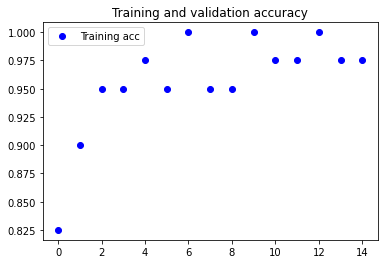

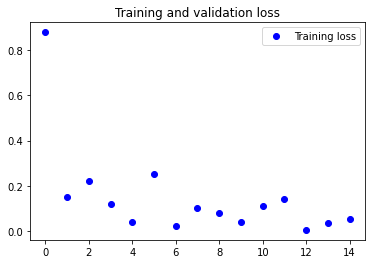

In [65]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

## If you want to try running the prediction from the saved model to validate the results, start from this step.

In [10]:
model = models.load_model('/content/drive/MyDrive/download/rustnorust_model-Mobile_Net.h5')

rust prob = [[1.]]
This is a Rust image


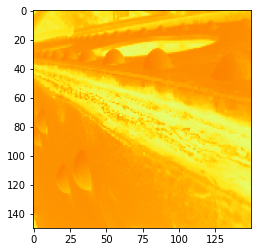

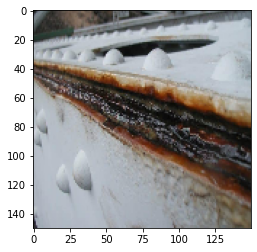

In [15]:
%matplotlib inline
img_path = '/content/drive/MyDrive/download/plane corrosion/rust.0006.jpg'

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
test_x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
test_x = test_x.reshape((1,) + test_x.shape)
test_x = test_x.astype('float32') / 255
rust_prob = model.predict(test_x)
print('rust prob =' ,rust_prob)
if (rust_prob > 0.5):
    print("This is a Rust image")
    I1=img.convert('L') # 'L' for gray scale mode
    plt.imshow(np.asarray(I1), cmap='Wistia')
    #plt.savefig('/content/drive/MyDrive/download/Resultat_corrosion/Positif-yellow/rust.9.jpg')
    plt.show()
    #img.save('/content/drive/MyDrive/download/Resultat_corrosion/Positif-non-yellow/rust.9.jpg')
    
else:
    print("This is a no Rust image")
    I1=img.convert('L') # 'L' for gray scale mode
    plt.imshow(np.asarray(I1), cmap='Blues')
    #plt.savefig('/content/drive/MyDrive/download/Resultat_corrosion/negatif-blue/no-rust.4.jpg')
    plt.show()
    #img.save('/content/drive/MyDrive/download/Resultat_corrosion/negatif-non-blue/no-rust.4.jpg')
plt.imshow(img)   

rust prob = [[0.97]]
This is a Rust image


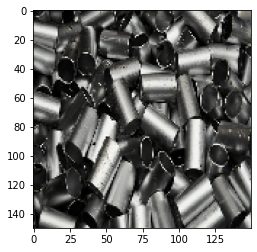

In [69]:
img_path = '/content/drive/MyDrive/download/norust/norust.0.jpg'
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
test_x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
test_x = test_x.reshape((1,) + test_x.shape)
test_x = test_x.astype('float32') / 255
rust_prob = model.predict(test_x)
print('rust prob =' ,rust_prob)
if (rust_prob > 0.5):
    print("This is a Rust image")
else:
    print("This is a no Rust image")

[[0.97]]
This is a Rust image


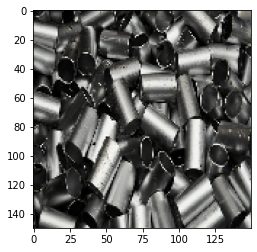

In [70]:
img_path = '/content/model-MobileNet/test/norust/norust.0.jpg'
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
test_x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
test_x = test_x.reshape((1,) + test_x.shape)
test_x = test_x.astype('float32') / 255
rust_prob = model.predict(test_x)
print(rust_prob)
if (rust_prob > 0.5):
    print("This is a Rust image")
else:
    print("This is a no Rust image")

In [13]:
base_dir = '/content/model-MobileNet'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')
       # save_to_dir='/home/anirban/rustnorust_b/images')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 519 images belonging to 2 classes.
Found 404 images belonging to 2 classes.


In [14]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        shuffle=False, 
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=10)
print('test acc:', test_acc)

Found 449 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


test acc: 0.824999988079071


In [73]:
test_data_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        shuffle=False, # v imp : do not shuffle in case of test data, when measuring precision and recall
        class_mode='binary')

test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)

val_preds = np.zeros((predictions.shape[0],1))
for i in range(predictions.shape[0]):
    if predictions[i]>0.5:
        val_preds[i] = 1
    else:
        val_preds[i] = 0

val_trues = test_data_generator.classes

labels = test_data_generator.class_indices.keys()


Found 449 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


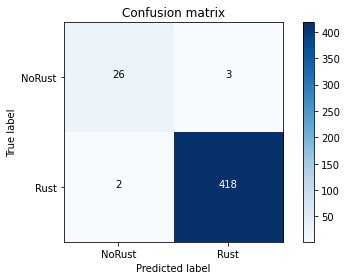

In [32]:
# Compute confusion matrix
class_names = ['NoRust','Rust']
cnf_matrix = confusion_matrix(val_trues, val_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [34]:
report = classification_report(val_trues, val_preds, target_names=labels)
print(report) 

              precision    recall  f1-score   support

      norust       0.93      0.90      0.91        29
        rust       0.99      1.00      0.99       420

    accuracy                           0.99       449
   macro avg       0.96      0.95      0.95       449
weighted avg       0.99      0.99      0.99       449



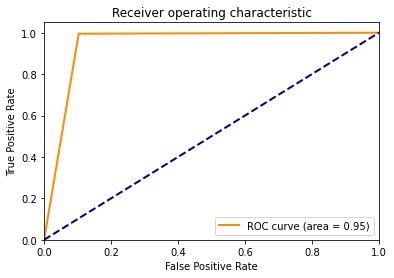

In [35]:
true_labels = val_trues
scores = val_preds
### actual code for roc + threshold charts start here 
# compute fpr, tpr, thresholds and roc_auc
fpr, tpr, thresholds = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr) # compute area under the curve
 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()